# Homework 4 

### Srujan Jabbireddy


In [1]:
#pip install gym
import io
import numpy as np
import pandas as pd
import itertools
#import matplotlib
import sys
#import gym

from gym.envs.toy_text import discrete
from collections import namedtuple
from matplotlib import pyplot as plt
#from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict

UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

Given 4 x 4 grid, action space \{Up = 0, Right= 1, Down=2, Left=3 }.\
$$\\
Reward Function, r(s_t,a_t) = \left\{ \begin{array}{cl}
0  & : \ {s_{t+1}} \\
-1 & : otherwise
\end{array} \right. \\
$$
Actions going off the edge leave you in your current state.

a) Implement the policy gradient method to learn the optimal policy

b) Compare the results with Q-learning method.

In [13]:
##Defining the grid world.

class GridworldEnv(discrete.DiscreteEnv):
    """
    Grid World environment from Sutton's Reinforcement Learning book chapter 4.
    You are an agent on an MxN grid and your goal is to reach the terminal
    state at the top left or the bottom right corner.
    For example, a 4x4 grid looks as follows:
    T  o  o  o
    o  x  o  o
    o  o  o  o
    o  o  o  T
    x is your position and T are the two terminal states.
    You can take actions in each direction (UP=0, RIGHT=1, DOWN=2, LEFT=3).
    Actions going off the edge leave you in your current state.
    You receive a reward of -1 at each step until you reach a terminal state.
    """

    metadata = {'render.modes': ['human', 'ansi']}

   # def __init__(self, shape=[5,5]):
    def __init__(self, shape=[4,4]):

        if not isinstance(shape, (list, tuple)) or not len(shape) == 2:
            raise ValueError('shape argument must be a list/tuple of length 2')

        self.shape = shape

        nS = np.prod(shape)#16=4*4
        nA = 4

        MAX_Y = shape[0]
        MAX_X = shape[1]

        P = {}
        grid = np.arange(nS).reshape(shape)
        it = np.nditer(grid, flags=['multi_index'])

        while not it.finished:
            s = it.iterindex
            y, x = it.multi_index

            # P[s][a] = (prob, next_state, reward, is_done)
            P[s] = {a : [] for a in range(nA)}#4 actions

            is_done = lambda s: s == 0 or s == (nS - 1)
            reward = 0.0 if is_done(s) else -1.0

            # We're stuck in a terminal state
            if is_done(s):
                P[s][UP] = [(1.0, s, reward, True)]
                P[s][RIGHT] = [(1.0, s, reward, True)]
                P[s][DOWN] = [(1.0, s, reward, True)]
                P[s][LEFT] = [(1.0, s, reward, True)]
            # Not a terminal state
            else:
                ns_up = s if y == 0 else s - MAX_X
                ns_right = s if x == (MAX_X - 1) else s + 1
                ns_down = s if y == (MAX_Y - 1) else s + MAX_X
                ns_left = s if x == 0 else s - 1
                P[s][UP] = [(1.0, ns_up, reward, is_done(ns_up))]
                P[s][RIGHT] = [(1.0, ns_right, reward, is_done(ns_right))]
                P[s][DOWN] = [(1.0, ns_down, reward, is_done(ns_down))]
                P[s][LEFT] = [(1.0, ns_left, reward, is_done(ns_left))]

            it.iternext()

        # Initial state distribution is uniform
        isd = np.ones(nS) / nS

        self.P = P

        super(GridworldEnv, self).__init__(nS, nA, P, isd)

    def _render(self, mode='human', close=False):
        """ Renders the current gridworld layout
         For example, a 4x4 grid with the mode="human" looks like:
            T  o  o  o
            o  x  o  o
            o  o  o  o
            o  o  o  T
        where x is your position and T are the two terminal states.
        """
        if close:
            return

        outfile = io.StringIO() if mode == 'ansi' else sys.stdout

        grid = np.arange(self.nS).reshape(self.shape)
        it = np.nditer(grid, flags=['multi_index'])
        while not it.finished:
            s = it.iterindex
            y, x = it.multi_index

            if self.s == s:
                output = " x "
            elif s == 0 or s == self.nS - 1:
                output = " T "
            else:
                output = " o "

            if x == 0:
                output = output.lstrip()
            if x == self.shape[1] - 1:
                output = output.rstrip()

            outfile.write(output)

            if x == self.shape[1] - 1:
                outfile.write("\n")

            it.iternext()


In [3]:
#Tuple episode lengths and rewards
EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])


In [4]:
           
def plot_episode_stats(stats,methods, smoothing_window=10, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.ylim([0,90])
    plt.title('Episode Length over Time of '+str(methods)+' method')
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.ylim([-40,0])
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    

    return fig1, fig2

In [5]:
def softmax_policy(Q, kappa, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function and epsilon.
    
    Args:
        Q: A dictionary that maps from state -> action-values.
            Each value is a numpy array of length nA (see below)
        epsilon: The probability to select a random action. Float between 0 and 1.
        nA: Number of actions in the environment.
    
    Returns:
        A function that takes the observation as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.
    
    """
    #def policy_fn(observation):
     #   A = np.ones(nA, dtype=float) * epsilon / nA
    #    best_action = np.argmax(Q[observation])
    #    A[best_action] += (1.0 - epsilon)
    #    return A
    #return policy_fn
    

    def policy_fn(observation):
        A = np.zeros(nA, dtype=float)
        A += np.exp((Q[observation] - np.max(Q[observation])/kappa))
        best_action = np.argmax(Q[observation])
        return A / A.sum()
    return policy_fn

### Defining Q-learning function

In [6]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.4, kappa=0.1):
    """
    Q-Learning algorithm: Off-policy TD control. Finds the optimal greedy policy
    while following an epsilon-greedy policy
    
    Args:
        env: OpenAI environment.
        num_episodes: Number of episodes to run for.
        discount_factor: discount factor.
        alpha: TD learning rate.
        epsilon: Chance to sample a random action. Float between 0 and 1.
    
    Returns:
        A tuple (Q, episode_lengths).
        Q is the optimal action-value function, a dictionary mapping state -> action values.
        stats is an EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """
    
    # The final action-value function.
    # A nested dictionary that maps state -> (action -> action-value).
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # Keeps track of useful statistics
    stats = EpisodeStats(episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    policy = softmax_policy(Q, kappa, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        # Reset the environment and pick the first action
        state = env.reset()
        
        # One step in the environment
        # total_reward = 0.0
        for t in itertools.count():
            
            # Take a step
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # TD Update
            best_next_action = np.argmax(Q[next_state])    
            td_target = reward + discount_factor * Q[next_state][best_next_action]
            Q[state][action] += alpha * (td_target-Q[state][action])
                
            if done:
                break
                
            state = next_state
    
    return Q, stats

## Implementing Ploicy Gradient method

In [7]:
# Our policy that maps state to action parameterized by w
def policy_grad(state,w):
    z = state*w
    exp = np.exp(z)
    return exp/np.sum(exp)

# Vectorized softmax Jacobian matrix
def softmax_grad(softmax):
    s = softmax.reshape(-1,1)
    return np.diagflat(s) - np.dot(s, s.T)


In [8]:
def policy_gradient(env, num_episodes,discount_factor=1.0, alpha=0.000025):

    nA = env.action_space.n
#    np.random.seed(1)

    # Init weight
#    w = np.random.rand(nA)
    w = np.array([0.25,0.25,0.25,0.25])

    stats = EpisodeStats(episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))  
    W = []
    W.append(w)
    # Main loop 
    
    for i_episode in range(num_episodes):
        # Print out which episode we're on, useful for debugging.
        if (i_episode + 1) % 100 == 0:
            print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()

        state = env.reset()

        grads = []
        rewards = []


        for t in itertools.count():

            # Sample from policy and take action in environment
            probs = policy_grad(state,w)
            action = np.random.choice(nA,p=probs)

            next_state,reward,done,_ = env.step(action)
            next_state = next_state#[None,:]
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            # Compute gradient and save with reward in memory for parameter updates
            dsoftmax = softmax_grad(probs)[action,:]
            dlog = dsoftmax / probs[action]

            grad = state*(dlog[:])

            grads.append(grad)
            rewards.append(reward)		

            # update to the new state
            state = next_state

            if done:
                break
                
        # parameter update
        for i in range(len(grads)):

            w += alpha * grads[i] * sum([ r * (discount_factor ** r) for t,r in enumerate(rewards[i:])])
               
        W.append(w)

    return W, stats

### Initialising grid world

In [9]:
env = GridworldEnv()
env._render()

T  o  o  o
x  o  o  o
o  o  o  o
o  o  o  T


### Initiating Q-learning
steps and total rewards to reach terminal state T

Episode 1000/1000.

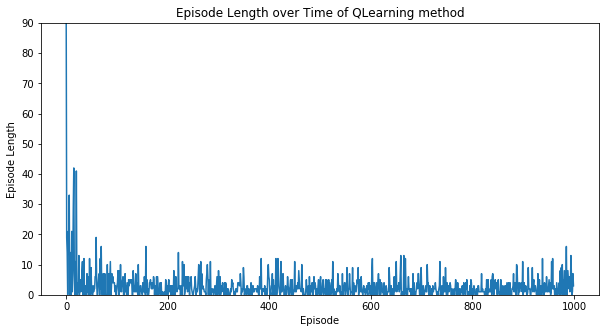

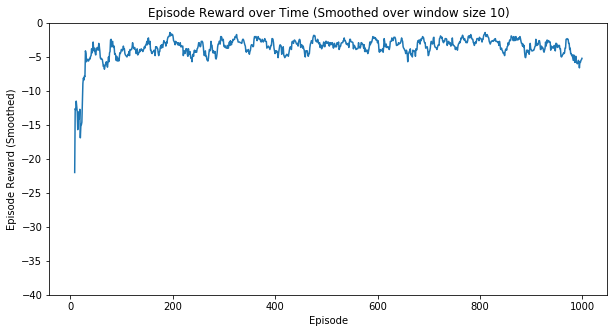

(<Figure size 720x360 with 1 Axes>, <Figure size 720x360 with 1 Axes>)

In [10]:
Q, stats = q_learning(env, 1000)
plot_episode_stats(stats,'QLearning')

### Initating Policy Gradient 
steps and total rewards to reach terminal state T

Episode 10000/10000.

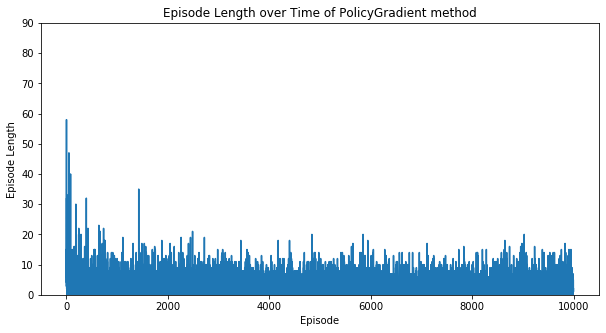

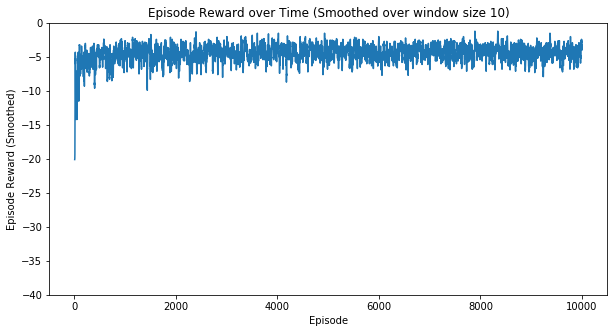

(<Figure size 720x360 with 1 Axes>, <Figure size 720x360 with 1 Axes>)

In [11]:
W, stats = policy_gradient(env, 10000)
plot_episode_stats(stats,'PolicyGradient')

In [12]:
nA = env.action_space.n
np.random.seed(1)

# Init weight
w = np.random.rand(nA)
print(w)

[4.17022005e-01 7.20324493e-01 1.14374817e-04 3.02332573e-01]


### From above graphs we can see that, Policy Gradient method converges faster than Q-learnig method. 
### Intial theta values do influence the speed of convergence.
### No matter what are the initial values, policy Gradient shows more perturbation than Q-learning method.